# Changing settings when solving PyBaMM models

[This](./models/SPM.ipynb) example notebook showed how to run an SPM battery model, using the default parameters, discretisation and solvers that were defined for that particular model. Naturally we would like the ability to alter these options on a case by case basis, and this notebook gives an example of how to do this, again using the SPM model.

### Table of Contents
1. [Default SPM model](#default)
1. [Changing the parameters](#parameters)
1. [Changing the discretisation](#discretisation)
1. [Changing the solver](#solver)

## The default SPM model  <a name="default"></a>

Below is the code to define and run the default SPM model included in PyBaMM (if this is unfamiliar to you, please see [this](./models/SPM.ipynb) notebook for more details)

In [1]:
import pybamm
import numpy as np
import os
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

# create the model
model = pybamm.lithium_ion.SPM()

# set the default model geometry
geometry = model.default_geometry

# set the default model parameters
param = model.default_parameter_values

# set the parameters for the model and the geometry
param.process_model(model)
param.process_geometry(geometry)

# mesh the domains
mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)

# discretise the model equations
disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
disc.process_model(model)

# Solve the model at the given time points
solver = model.default_solver
n = 100
t_eval = np.linspace(0, 0.2, n)
solver.solve(model, t_eval)

To verify the solution, we can look at a plot of the Terminal voltage over time

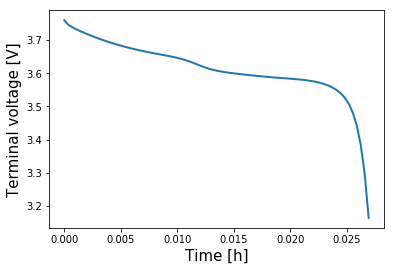

In [2]:
t, y = solver.t, solver.y
time = pybamm.ProcessedVariable(model.variables["Time [h]"], t, y)(t)
voltage = pybamm.ProcessedVariable(model.variables["Terminal voltage [V]"], t, y)(t)
plt.plot(time, voltage, lw=2, label=model.name)
plt.xlabel("Time [h]", fontsize=15)
plt.ylabel("Terminal voltage [V]", fontsize=15)
plt.show()

## Changing the model parameters <a name="parameters"></a>

The parameters are defined using the [`pybamm.ParameterValues`](https://pybamm.readthedocs.io/en/latest/source/parameters/parameter_values.html) class, which takes either a python dictionary or CSV file with the mapping between parameter names and values.

First lets have a look at the default parameters that are included with the SPM model:

In [3]:
format_str = '{:<75}  {:>20}'
print(format_str.format('PARAMETER', 'VALUE'))
print("-"*97)
for key, value in model.default_parameter_values.items():
    print(format_str.format(key, value))

PARAMETER                                                                                   VALUE
-------------------------------------------------------------------------------------------------
Reference temperature [K]                                                                  298.15
Negative electrode width [m]                                                               0.0001
Separator width [m]                                                                       2.5e-05
Positive electrode width [m]                                                               0.0001
Electrode height [m]                                                          0.13699999999999998
Electrode depth [m]                                                                         0.207
Negative current collector thickness [m]                                                  2.5e-05
Positive current collector thickness [m]                                                  2.5e-05
Number of electrodes

Most of the parameters in this list have numerical values. Some have string values, that point to particular python functions within PyBaMM. These denote parameters that vary over time and/or space, in a manner defined by the given python function. For the moment we will ignore these, and focus on altering one of the numerical parameters.

The class [`pybamm.ParameterValues`](https://pybamm.readthedocs.io/en/latest/source/parameters/parameter_values.html) acts like the normal python `dict` data structure, so you can read or write individual parameters accordingly:

In [4]:
variable = "Typical current [A]"
old_value = param[variable]
param[variable] = 1.4
new_value = param[variable]
print(variable,'was',old_value)
print(variable,'now is',param[variable])

Typical current [A] was 1
Typical current [A] now is 1.4


Once this parameter has been changed, the most foolproof way of re-running the simulation is to go through the entire process given above of (1) generating the model, (2) setting the parameters of the model, (3) meshing the domain, (4) discretising the equations, and finally (5), solving the equations. However, this is only neccessary in a small number of cases, if for example you change one of the geometry parameters, such as the *Negative electrode width*. In this case you would need to remesh the geometry as the relative length of the electrodes would have altered. This would in turn require you to re-discretise the model equations. 

In most use-cases, however, fully regenerating the discretisated model is not neccessary, and you can simply use the `update_model` function for [`pybamm.ParameterValues`](https://pybamm.readthedocs.io/en/latest/source/parameters/parameter_values.html)

In [5]:
param.update_model(model, disc)

Now we can simply call the solver again to solve the new model

In [6]:
solver.solve(model, t_eval)

We can compare the Terminal voltage calculated using both the old and new parameters

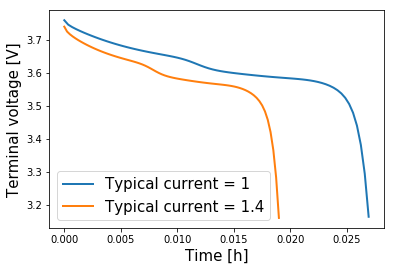

In [7]:
t, y = solver.t, solver.y
new_voltage = pybamm.ProcessedVariable(model.variables["Terminal voltage [V]"], t, y)(t)
new_time = pybamm.ProcessedVariable(model.variables["Time [h]"], t, y)(t)
plt.plot(time, voltage, lw=2, label="Typical current = {}".format(old_value))
plt.plot(new_time, new_voltage, lw=2, label="Typical current = {}".format(new_value))
plt.xlabel("Time [h]", fontsize=15)
plt.ylabel("Terminal voltage [V]", fontsize=15)
plt.legend(fontsize=15)
plt.show()

## Changing the discretisation <a name="discretisation"></a>

The chosen spatial discretisation method to use for each domain is passed into the [`pybamm.Discretisation`](https://pybamm.readthedocs.io/en/latest/source/discretisations/discretisation.html) class as one of its arguments. The default spatial methods for the SPM class are given as:


In [8]:
print(format_str.format('DOMAIN', 'DISCRETISED BY'))
print("-"*82)
for key, value in model.default_spatial_methods.items():
    print(format_str.format(key, value.__name__))

DOMAIN                                                                             DISCRETISED BY
----------------------------------------------------------------------------------
macroscale                                                                           FiniteVolume
negative particle                                                                    FiniteVolume
positive particle                                                                    FiniteVolume
negative electrode                                                                   FiniteVolume
separator                                                                            FiniteVolume
positive electrode                                                                   FiniteVolume


To change the discretisation for a particular domain, you can update the spatial methods `dict` with the new discretiation class  that you wish to use, for example:

In [9]:
spatial_methods = model.default_spatial_methods
spatial_methods["negative particle"] = pybamm.FiniteVolume

**NOTE**: at the current time, PyBaMM only supports Finite Volume discretisation, so the above does not alter the default discretisations. We plan on adding additional discretiations methods soon, so watch this space

Now that we have set the new discretisation method, we can proceed to re-discretise and then solve the model. Note that in this case we need to regenerate the model using `pybamm.lithium_ion.SPM`, as the original model information was lost when we discretised it [above](#default). 

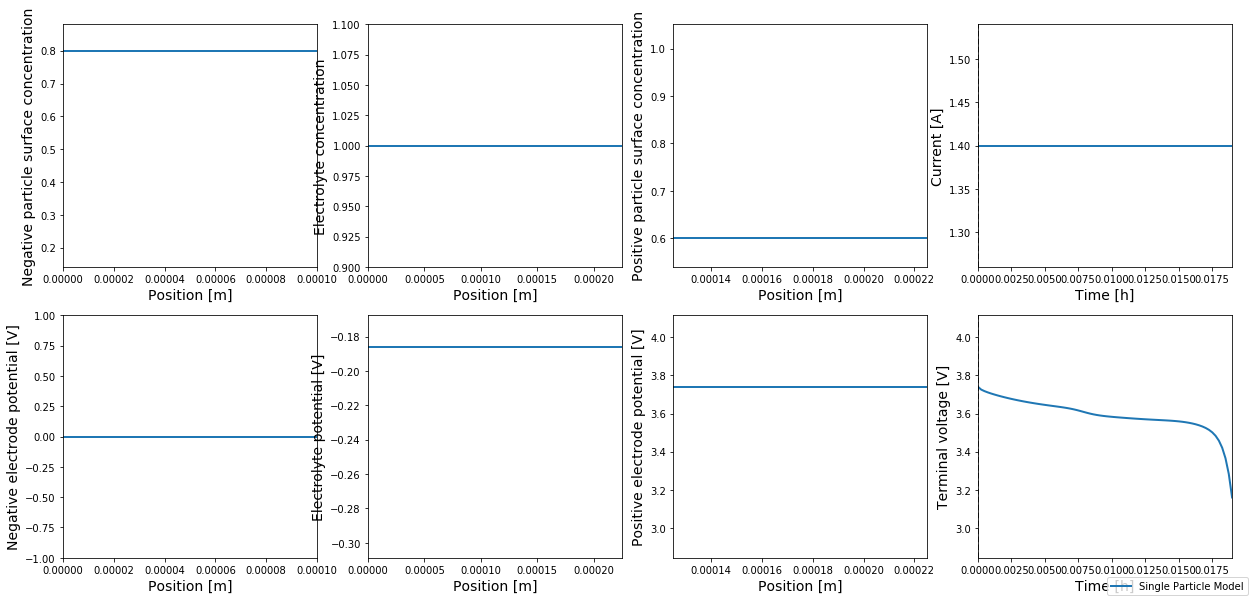

In [10]:
# re-generate the model and set parameters
model = pybamm.lithium_ion.SPM()
param.process_model(model)

# re-discretise the model ...
disc = pybamm.Discretisation(mesh, spatial_methods)
disc.process_model(model)

# ... and finally solve it
solver.solve(model, t_eval)
pybamm.QuickPlot(model, mesh, solver).plot(0)

## Changing the solver <a name="solver"></a>

Which method you use to integrate the discretisated model in time can also be changed. PyBaMM currently has three different solver classes, which are:

1. [pybamm.ScipySolver](https://pybamm.readthedocs.io/en/latest/source/solvers/scipy_solver.html). Uses normal python `scipy` ode integration classes.
1. [ScikitsOdeSolver](https://pybamm.readthedocs.io/en/latest/source/solvers/scikits_solvers.html). Uses Sundials CVODE ODE time-stepper.
1. [ScikitsDaeSolver](https://pybamm.readthedocs.io/en/latest/source/solvers/scikits_solvers.html). Uses Sundial IDA DAE time-stepper.

In [11]:
print('Default solver for SPM model:',type(model.default_solver).__name__)

Default solver for SPM model: ScikitsOdeSolver


To change this, simply create a new solver using one of the above classes and use it to solve your discretised model

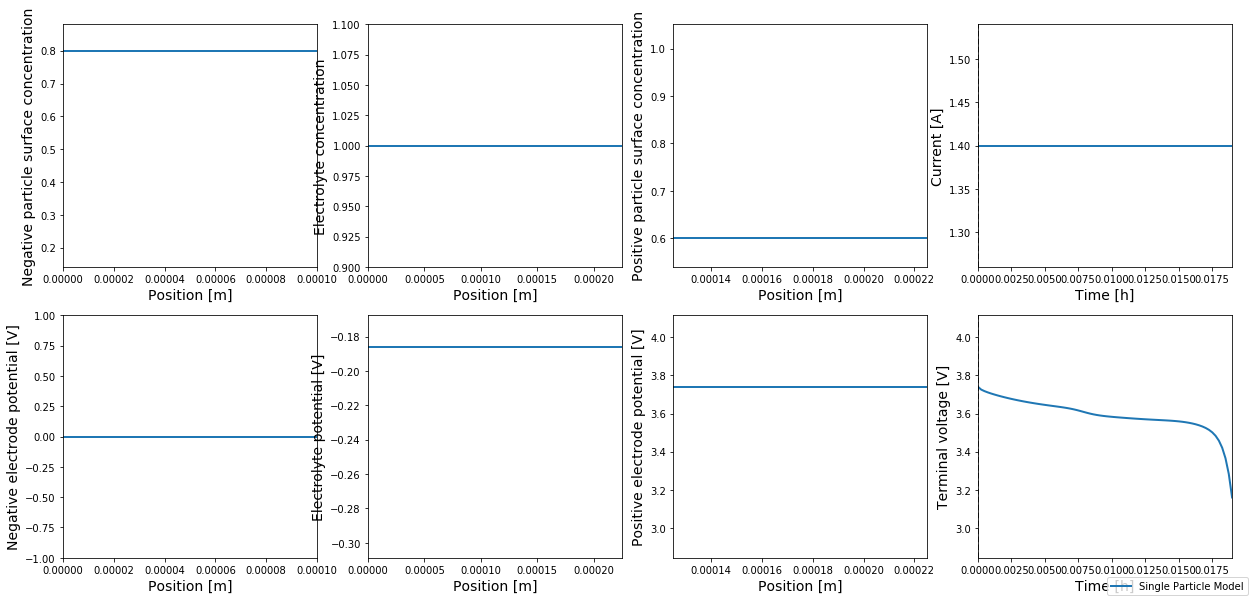

In [12]:
new_solver = pybamm.ScipySolver()
new_solver.solve(model, t_eval)
pybamm.QuickPlot(model, mesh, new_solver).plot(0)